<center>

# __Introduction to SHAP__

<br>

Dr. [Jose Maria Alonso-Moral](https://citius.gal/team/jose-maria-alonso-moral/)

_Centro Singular de Investigación en Tecnoloxías Intelixentes (CiTIUS)_

_Universidade de Santiago de Compostela_

_ETSE-USC, Campus Vida, Santiago de Compostela, Spain_

<br>

Mr. [Pablo Miguel Perez-Ferreiro](https://citius.gal/team/pablo-miguel-perez-ferreiro/)

_Centro Singular de Investigación en Tecnoloxías Intelixentes (CiTIUS)_

_Universidade de Santiago de Compostela_

_ETSE-USC, Campus Vida, Santiago de Compostela, Spain_

<br>

__27 January 2026__
 
__Explainable and Trustworthy AI__

<br>

![MIA.png](MIA.png)

</center>

# 1. **Introduction**

This interactive tutorial includes supplementary material for the first TXAI in the Lab hands-on session (**I1. "Introduction to SHAP"**) in the Subject **Explainable and Trustworthy AI** (Master in Artificial Intelligence). The session is leaded by [Jose M. Alonso-Moral](https://citius.gal/team/jose-maria-alonso-moral) and [Pablo Miguel Perez-Ferreiro](https://citius.gal/team/pablo-miguel-perez-ferreiro/) at USC, [Samuel Suárez Marcote](https://pdi.udc.es/es/File/Pdi/UA4VL![imagen.png](attachment:imagen.png)) at UDC, and [David Nicholas Olivieri Cecchi](https://www.uvigo.gal/es/universidad/administracion-personal/pdi/david-nicholas-olivieri-cecchi) at UVigo.

# 2. **Settings**

In this section, we prepare the software needed to run the notebook. Please abstain from changing anything in this section unless you're prompted to by your teachers, as it may break the notebook's functionality.

In [1]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

import os

os.system("pip install simplenlg --quiet")
os.system("pip install tabulate --quiet")
os.system("pip install numba==0.59.1 --quiet")
os.system("pip install salib==1.3.3 --quiet")
os.system("pip install numpy==1.26.4 --quiet")
os.system("pip install shap==0.46.0 --quiet")
os.system("pip install interpret==0.5.0 --quiet")

0

In [2]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

import warnings
warnings.filterwarnings('ignore')

# Loading plot tool (for ploting fuzzy sets and rules)
import matplotlib.pyplot as plt

# Loading pandas for their DataFrames and some management functions
import pandas as pd

# Loading seaborn for plotting
import seaborn as sns

# Loading numpy for utilities
import numpy as np

# Loading lib to deal with arff files
from scipy.io.arff import loadarff

# Loading sklearn and several of its modules: they will allow us to build and validate the models whose interpretability we will study
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.tree import export_text

# Loading InterpretML, a library specialized in offering explainable by design models.
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# Loading a library to handle SHAP Values
import shap

# Loading Graphviz in order to plot Decision Trees
import graphviz

In [3]:
## this code is developed by Jose Maria Alonso-Moral
## Auxiliary functions for the notebook:

# Plots a Pareto fron between two variables (x, y), labeled (labelx, labely), with the x-axis' limits defined (minx, maxx)
def plot_pareto_front(x,y,n,labelx,labely,minx,maxx):
  plt.title("Pareto Front")
  plt.ylabel(labelx)
  plt.xlabel(labely)
  plt.axis([minx, maxx, 0, 1])
  c=["ro","bo","go","rs","bs","gs","r*","b*","g*","r+","b+","g+"]
  for m in n:
    m_idx= n.index(m)
    plt.plot(x[m_idx], y[m_idx], c[m_idx], label=m)

  plt.grid(True)
  plt.legend()
  plt.show()

# Extracts the length of SHAP-based explanations; used on this practical as a surrogate interpretability metric
def get_shap_explanation_length(single_lower_triangular_interactions, indexes=None, th=0.9):
    # Calculate the cumulative sum and absolute value using numpy functions
    shap_cumsum = np.cumsum(np.abs(single_lower_triangular_interactions))
    # Normalize the cumulative sum
    normalised_shap_cumsum = shap_cumsum / shap_cumsum[-1]
    # Find the index of the first element that exceeds the threshold using a loop
    first_above_idx = 0
    for i, val in enumerate(normalised_shap_cumsum):
        if val > th:
            first_above_idx = i
            break
    # Calculate the SHAP explanation length
    shap_expl_length = first_above_idx
    return shap_expl_length

# 3. **Interpretable systems: from the ground up**

In this section, we will go through the process of building an interpretable system step-by-step, working with both interpretable-by-design and opaque models. In this sense, we will:
- Import and pre-process a suitable dataset.
- Build and validate several ML models for it.
- Explore the properties of the built models, and perform a first attempt at interpreting those which are transparent through direct inspection.
- Utilize SHAP Values as a post-hoc explainability tool that allows us to overcome some of the problems brought by direct inspection.
- Perform a preliminary evaluation of the trade-offs between performance and explainability that the field of TXAI usually involves.

## 3.1. **Loading data and preliminary exploration**

We will be working with the [Pima Indians Diabetes Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) in the usual [Weka arff format](https://waikato.github.io/weka-wiki/formats_and_processing/arff/).

A classical example dataset for machine learning, it contains 768 instances, all of them describing females of age coming from the Pima Indian heritage. Its intended usage is binary classification, predicting the onset of diabetes according to 8 features defined by the [World Health Organization](https://www.who.int/en):
* **Number of times pregnant**
* **Plasma glucose concentration**
* **Diastolic blood pressure**
* **Triceps skin fold thickness**
* **Two hour serum insulin**
* **Body mass index**
* **Diabetes pedigree function**
* **Age**

We will begin by importing it from your workspace, and then we will pre-process the data and explore it.

In [4]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# Importing the train and test sets from the arff files, and setting the class and attribute names.
file_train = 'testlib/PIMA/PIMA.train.0.arff'
file_test = 'testlib/PIMA/PIMA.test.0.arff'
with open(file_train) as f:
    train_data_value, attributes = loadarff(f)
    f.close()
with open(file_test) as f:
    test_data_value, attributes = loadarff(f)
    f.close()
pima_class_names= ['tested_negative','tested_positive']
pima_fnames = ["Number of times pregnant", "Plasma glucose concentration", "Diastolic blood_pressure", "Triceps skin fold thickness", "Two hour serum insulin", "Body mass index", "Diabetes pedigree function", "Age"]

# We prepare the train sets
class_names = np.array(pima_class_names)
feature_names = np.array(attributes.names())
df=pd.DataFrame(train_data_value)
df.columns = feature_names
target = df.pop('class')
target_onehot = pd.get_dummies(target)[b'2.0'] 
x_tr = df
y_tr = target_onehot
y_tr_num = [float(out_class) for out_class in y_tr] # we will need the numerical outputs to simulate regression

# And the test sets too
df_test=pd.DataFrame(test_data_value)
x_test = df_test
target_test = df_test.pop('class')
target_test_onehot = pd.get_dummies(target_test)[b'2.0']
y_test = target_test_onehot
y_test_num = [float(out_class) for out_class in y_test] # likewise

# Print some general information of the dataset
print(f'Class names for the PIMA Dataset:\n\t{", ".join(list(class_names))}\nFeature names for the PIMA Dataset:\n\t{", ".join(list(feature_names))}')

Class names for the PIMA Dataset:
	tested_negative, tested_positive
Feature names for the PIMA Dataset:
	Number_of_times_pregnant, Plasma_glucose_concentration, Diastolic_blood_pressure, Triceps_skin_fold_thickness, 2_Hour_serum_insulin, Body_mass_index, Diabetes_pedigree_function, Age, class


In [5]:
## this code is developed by Jose Maria Alonso-Moral

# Check how the tabular data looks
df.head(n=10)

Number_of_times_pregnant  Plasma_glucose_concentration  \
0                       5.0                         103.0   
1                       7.0                         103.0   
2                      10.0                         101.0   
3                       5.0                         139.0   
4                       0.0                          74.0   
5                       5.0                         136.0   
6                       3.0                         176.0   
7                       3.0                         128.0   
8                       7.0                         184.0   
9                       3.0                          99.0   

   Diastolic_blood_pressure  Triceps_skin_fold_thickness  \
0                     108.0                         37.0   
1                      66.0                         32.0   
2                      76.0                         48.0   
3                      64.0                         35.0   
4                      52.0                         10.0   
5                      82.0                          0.0   
6                      86.0                         27.0   
7                      72.0                         25.0   
8                      84.0                         33.0   
9                      62.0                         19.0   

   2_Hour_serum_insulin  Body_mass_index  Diabetes_pedigree_function   Age  
0                   0.0             39.2                       0.305  65.0  
1                   0.0             39.1                       0.344  31.0  
2                 180.0             32.9                       0.171  63.0  
3                 140.0             28.6                       0.411  26.0  
4                  36.0             27.8                       0.269  22.0  
5                   0.0              0.0                       0.640  69.0  
6                 156.0             33.3                       1.154  52.0  
7                 190.0             32.4                       0.549  27.0  
8                   0.0             35.5                       0.355  41.0  
9                  74.0             21.8                       0.279  26.0

<Axes: xlabel='class', ylabel='count'>

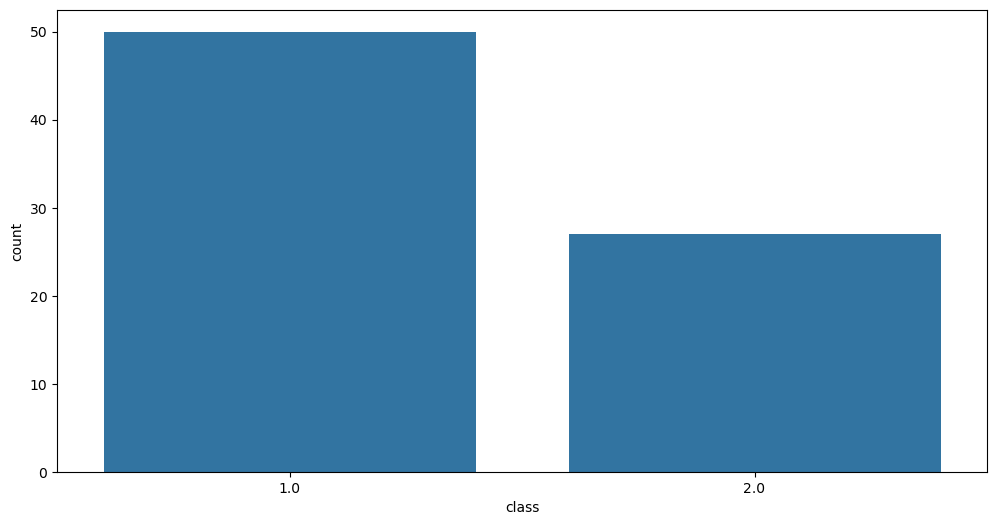

In [6]:
## this code is developed by Jose Maria Alonso-Moral

# Take a look at the output class distribution for the test set. Remember that 1.0 means tested_negative and 2.0 means tested_positive.
df_test=pd.DataFrame(test_data_value)
plt.figure(figsize=(12,6))
sns.countplot(x='class', data=df_test)

## 3.2. **Model building**

Now, we build some ML models over the dataset we just imported: two Decision Trees (which are interpretable-by-design) and a Random Forest (which is opaque). We will also perform a simple validation of their performance.

Some notes about the model creation:
- We are using the default parameters in most situations; changing them will change the performance and, potentially, the interpretations you can extract from the trees. For the purposes of this practical session, we will not go very in-depth about it other than showing the differences that appear between an unlimited Decision Tree and one that has a hard-cap on its depth.
- You will see below that we train Regressor equivalents of all three models. This is done to show that the approach we follow during this section works just fine for that setting too, but it is otherwise **not correct**. As mentioned on the previous section, the dataset we are employing is a **binary classification** dataset, and even though that type of problem can be approximated by a regression on the [0.0, 1.0] range, it is **generally improper** to utilize a dataset on a context it was not designed for. Always be mindful of the type of data you are working with!

You can check official documentation of the sklearn models we are going to use here: [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [7]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# We fit a Decision Tree, a Decision Tree of limited depth, and a Random Forest.
dtc = tree.DecisionTreeClassifier()
dtc.fit(x_tr, y_tr)

dtc5 = tree.DecisionTreeClassifier(max_depth=5)
dtc5.fit(x_tr, y_tr)

rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(x_tr, y_tr)

models = [dtc, dtc5, rfc]
models_names = ['TREE', 'TREE5', 'RF']

# Cross-validation for the models just fit above 
print("1) Cross-validation (over training data)")
scorings = ['accuracy', 'f1']  # For binary classification
nF= 5
for model, model_name in zip(models, models_names):
    cv_results = cross_validate(model, x_tr, y_tr, cv=nF, 
                            scoring=scorings,
                            return_train_score=False)
    print(f'\n\t{model_name}:')
    print(f'\t\tCorrect Classification Rate [Average (St. Dev)] = {np.mean(cv_results["test_accuracy"]):.3f} ({np.std(cv_results["test_accuracy"]):.3f})')
    print(f'\t\tF-Score [Average (St. Dev)] = {np.mean(cv_results["test_f1"]):.3f} ({np.std(cv_results["test_f1"]):.3f})')

# Test with unknown instances
print("\n\n2) Test (with previously unseen data)")
models_acc=[]
target_names = ['class 1', 'class 2']
for model, model_name in zip(models, models_names):
    sc = round(model.score(x_test, y_test), 3) # we round the accuracy to 3 decimals and append it to the list of model accuracies for the test set
    models_acc.append(sc)
    # Mean accuracy of self.predict(x_test) wrt y_test
    print(f'\n\t{model_name}:')
    print(f'\t\tCorrect Classification Rate: {models_acc[-1]:.3f}')
    y_pred= model.predict(x_test)
    print(classification_report(y_test, model.predict(x_test), target_names=target_names))

1) Cross-validation (over training data)

	TREE:
		Correct Classification Rate [Average (St. Dev)] = 0.705 (0.028)
		F-Score [Average (St. Dev)] = 0.575 (0.041)

	TREE5:
		Correct Classification Rate [Average (St. Dev)] = 0.745 (0.023)
		F-Score [Average (St. Dev)] = 0.615 (0.028)

	RF:
		Correct Classification Rate [Average (St. Dev)] = 0.760 (0.029)
		F-Score [Average (St. Dev)] = 0.624 (0.055)


2) Test (with previously unseen data)

	TREE:
		Correct Classification Rate: 0.675
              precision    recall  f1-score   support

     class 1       0.75      0.76      0.75        50
     class 2       0.54      0.52      0.53        27

    accuracy                           0.68        77
   macro avg       0.64      0.64      0.64        77
weighted avg       0.67      0.68      0.67        77


	TREE5:
		Correct Classification Rate: 0.727
              precision    recall  f1-score   support

     class 1       0.78      0.80      0.79        50
     class 2       0.62      0.59

---

In [8]:
## this code is developed by Pablo Miguel Perez-Ferreiro

# Keep in mind we need to use the numerical version of the output for regression equivalents
dtr = tree.DecisionTreeRegressor()
dtr.fit(x_tr, y_tr_num)

dtr5 = tree.DecisionTreeRegressor(max_depth=5)
dtr5.fit(x_tr, y_tr_num)

rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(x_tr, y_tr_num)

models_r = [dtr, dtr5, rfr]
models_r_names = ['TREE-R', 'TREE5-R', 'RF-R']

# We don't validate for Regressors; it can be done, but it does not fit this problem.

## 3.3. **Visualization**

An advantage of the interpretable models we just trained (i.e., the Decision Trees) is that they can be easily visualized. When DTs are reasonably shallow, this may suffice to explain:
- Their **global behavior**, as the general structure of the tree provides a certain understanding of the tree's priorities when it comes to classifying instances. In this sense, a Decision Tree always gauges the importance of its features (implicitly): consider that most algorithms for decision tree creation build the decision splits based on *information gain* measures, which means that more *informative* features will be placed higher on the tree's branches.
- Their **local behavior**, as any given instance will follow a certain path until reaching a leaf node. This path of conditions can be understood as an ad-hoc rule that justifies the instance's classification.

These two properties are limited, however, by the features of the tree holding a degree of meaning, i.e., highly complex features may not be easily understood, thus limiting their usefulness as an explanatory tool. Plain visualization can also be unwieldy when DTs are very deep, thus nesting many splits. You can check that effect by comparing the graphical representations below (unlimited depth vs. limited depth); in them each node lists:
- The split condition. Leaf nodes omit this, as there are no more conditions to check.
- The Gini index, which measures inequality and is the measure that guides splits. This can be changed for entropy during model creation; check the documentation previously linked.
- The number of samples that have 'reached' that node.
- The distribution of classes amongst those samples: [A, B] represents [tested_negative, tested_positive].

|--- Plasma glucose concentration <= 143.50
|   |--- Body mass index <= 27.35
|   |   |--- Plasma glucose concentration <= 105.50
|   |   |   |--- class: False
|   |   |--- Plasma glucose concentration >  105.50
|   |   |   |--- Body mass index <= 9.80
|   |   |   |   |--- Number of times pregnant <= 7.00
|   |   |   |   |   |--- class: False
|   |   |   |   |--- Number of times pregnant >  7.00
|   |   |   |   |   |--- class: True
|   |   |   |--- Body mass index >  9.80
|   |   |   |   |--- Plasma glucose concentration <= 108.50
|   |   |   |   |   |--- Age <= 50.00
|   |   |   |   |   |   |--- Diastolic blood_pressure <= 65.00
|   |   |   |   |   |   |   |--- Two hour serum insulin <= 52.00
|   |   |   |   |   |   |   |   |--- Diabetes pedigree function <= 0.21
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- Diabetes pedigree function >  0.21
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- Two hour seru

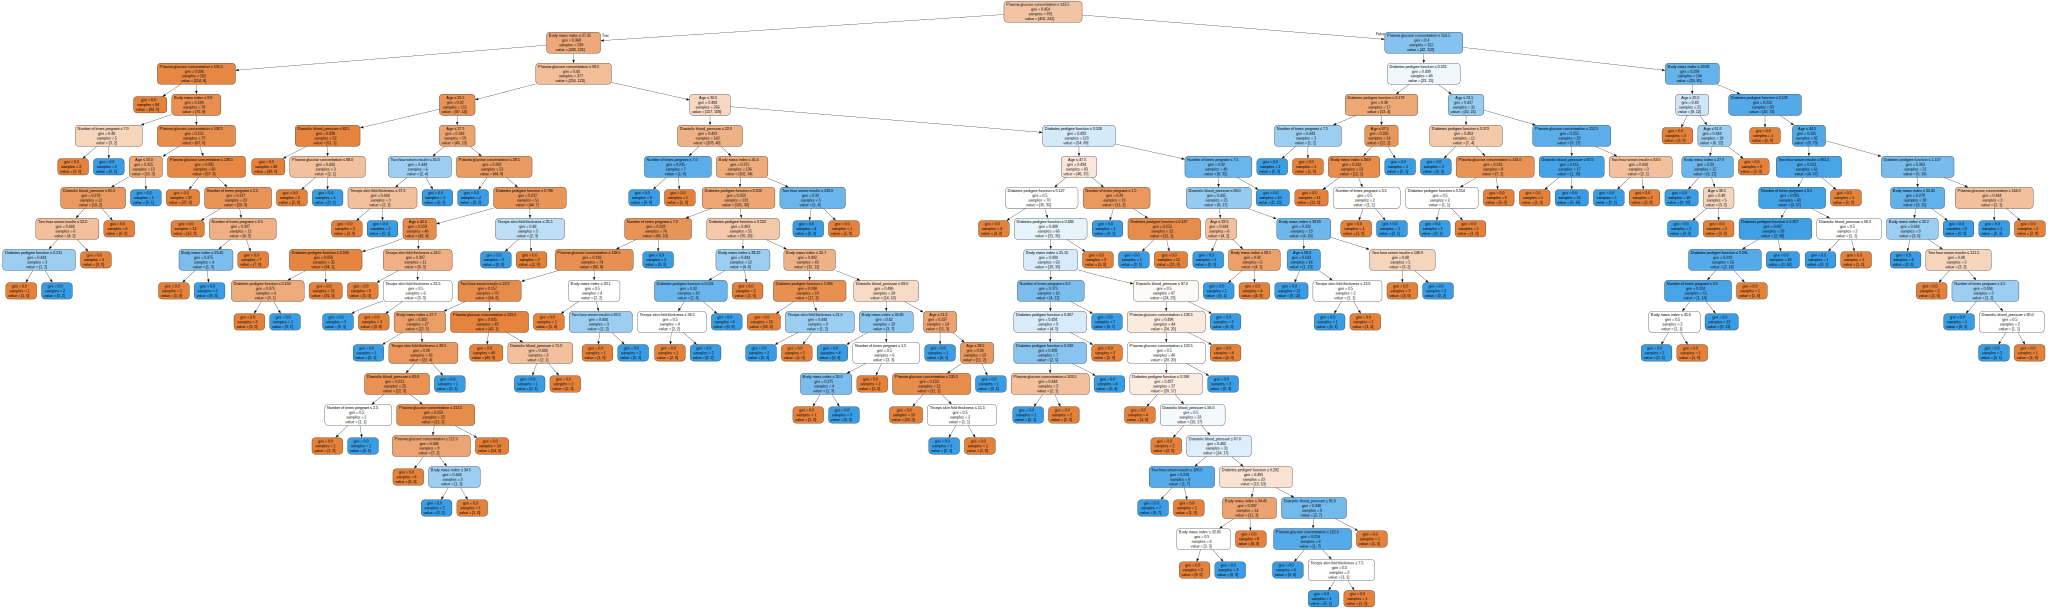

In [9]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro
# Visualizing entire decision tree
print(export_text(dtc, feature_names=pima_fnames))
dot_data = tree.export_graphviz(dtc, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=pima_fnames) 
graph = graphviz.Source(dot_data) 
graph#.render(format='png') # Big trees are not very easy to examine on the notebook, so you may uncomment the render call to save them to a PNG file so that you can check out the graph elsewhere.

---

In [10]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro
# Visualizing the reduced tree
print(export_text(dtc5, feature_names=pima_fnames))
dot_data5 = tree.export_graphviz(dtc5, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=pima_fnames) 
graph5 = graphviz.Source(dot_data5) 
graph5#.render(format='png') # Big trees are not very easy to examine on the notebook, so you may uncomment the render call to save them to a PNG file so that you can check out the graph elsewhere.

|--- Plasma glucose concentration <= 143.50
|   |--- Body mass index <= 27.35
|   |   |--- Plasma glucose concentration <= 105.50
|   |   |   |--- class: False
|   |   |--- Plasma glucose concentration >  105.50
|   |   |   |--- Body mass index <= 9.80
|   |   |   |   |--- Number of times pregnant <= 7.00
|   |   |   |   |   |--- class: False
|   |   |   |   |--- Number of times pregnant >  7.00
|   |   |   |   |   |--- class: True
|   |   |   |--- Body mass index >  9.80
|   |   |   |   |--- Plasma glucose concentration <= 108.50
|   |   |   |   |   |--- class: False
|   |   |   |   |--- Plasma glucose concentration >  108.50
|   |   |   |   |   |--- class: False
|   |--- Body mass index >  27.35
|   |   |--- Plasma glucose concentration <= 99.50
|   |   |   |--- Age <= 25.50
|   |   |   |   |--- Diastolic blood_pressure <= 83.50
|   |   |   |   |   |--- class: False
|   |   |   |   |--- Diastolic blood_pressure >  83.50
|   |   |   |   |   |--- class: False
|   |   |   |--- Age >  25

---
We can also plot the regressor trees. You'll see their format is mostly equivalent to that above, although they use squared error instead of Gini index (regression vs. classification, as said) and report the value that would be assigned for a data instance that ended up on that node.


|--- Plasma glucose concentration <= 143.50
|   |--- Body mass index <= 27.35
|   |   |--- Plasma glucose concentration <= 105.50
|   |   |   |--- value: [0.00]
|   |   |--- Plasma glucose concentration >  105.50
|   |   |   |--- Body mass index <= 9.80
|   |   |   |   |--- Number of times pregnant <= 7.00
|   |   |   |   |   |--- value: [0.00]
|   |   |   |   |--- Number of times pregnant >  7.00
|   |   |   |   |   |--- value: [1.00]
|   |   |   |--- Body mass index >  9.80
|   |   |   |   |--- Plasma glucose concentration <= 108.50
|   |   |   |   |   |--- value: [0.23]
|   |   |   |   |--- Plasma glucose concentration >  108.50
|   |   |   |   |   |--- value: [0.05]
|   |--- Body mass index >  27.35
|   |   |--- Plasma glucose concentration <= 99.50
|   |   |   |--- Age <= 25.50
|   |   |   |   |--- Diastolic blood_pressure <= 83.50
|   |   |   |   |   |--- value: [0.00]
|   |   |   |   |--- Diastolic blood_pressure >  83.50
|   |   |   |   |   |--- value: [0.33]
|   |   |   |--- A

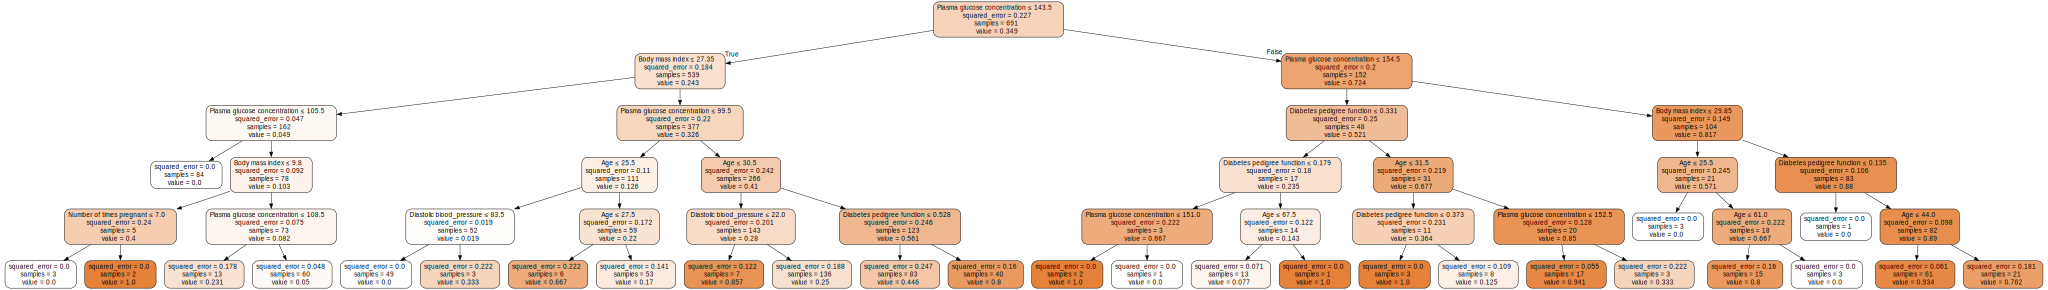

In [11]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro
# Visualizing the reduced regressor tree
print(export_text(dtr5, feature_names=pima_fnames))
dot_data5r = tree.export_graphviz(dtr5, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=pima_fnames) 
graph5r = graphviz.Source(dot_data5r) 
graph5r#.render(format='png') # Big trees are not very easy to examine on the notebook, so you may uncomment the render call to save them to a PNG file so that you can check out the graph elsewhere.

---
Be aware that, convenient as it may be, this type of interpretation **can't** be performed for all (or most) ML approaches. For instance, the Random Forest we just trained can't be visualized like this, and in fact is not interpretable by itself. However, Random Forests are usually very strong in terms of predictive performance, and thus ideally, we would like to make them at least a bit understandable. We will need a different tool for this. 

---

### Exercise I1.1

Try to build some alternate versions of the Decision Trees we obtained, by changing the parameters on the constructor call. You don't need to do this for Regressors, so refer to [this](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) documentation. You don't need to be exhaustive: trying two or three is enough. You may keep limiting their depth to keep their interpretation manageable (but you don't need to).

Plot these new decision trees and compare them to the two trees (**dtc** and **dtc5**) given as illustrative examples in the previous cells. Are they significantly different? Extract some conclusions as to why/why not, and summarize a few key insights onto the diabetes prediction problem you can distill from the trends shown by your set of trees.


In [24]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# We fit a Decision Tree, a Decision Tree of limited depth, and a Random Forest.
dtcv1 = tree.DecisionTreeClassifier(max_depth=5, criterion='entropy')
dtcv1.fit(x_tr, y_tr)

dtcv2 = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=3)
dtcv2.fit(x_tr, y_tr)

models = [dtcv1, dtcv2]
models_names = ['TREEv1', 'TREEv2']

# Cross-validation for the models just fit above 
print("1) Cross-validation (over training data)")
scorings = ['accuracy', 'f1']  # For binary classification
nF= 5
for model, model_name in zip(models, models_names):
    cv_results = cross_validate(model, x_tr, y_tr, cv=nF, 
                            scoring=scorings,
                            return_train_score=False)
    print(f'\n\t{model_name}:')
    print(f'\t\tCorrect Classification Rate [Average (St. Dev)] = {np.mean(cv_results["test_accuracy"]):.3f} ({np.std(cv_results["test_accuracy"]):.3f})')
    print(f'\t\tF-Score [Average (St. Dev)] = {np.mean(cv_results["test_f1"]):.3f} ({np.std(cv_results["test_f1"]):.3f})')

# Test with unknown instances
print("\n\n2) Test (with previously unseen data)")
models_acc=[]
target_names = ['class 1', 'class 2']
for model, model_name in zip(models, models_names):
    sc = round(model.score(x_test, y_test), 3) # we round the accuracy to 3 decimals and append it to the list of model accuracies for the test set
    models_acc.append(sc)
    # Mean accuracy of self.predict(x_test) wrt y_test
    print(f'\n\t{model_name}:')
    print(f'\t\tCorrect Classification Rate: {models_acc[-1]:.3f}')
    y_pred= model.predict(x_test)
    print(classification_report(y_test, model.predict(x_test), target_names=target_names))

1) Cross-validation (over training data)

	TREEv1:
		Correct Classification Rate [Average (St. Dev)] = 0.728 (0.047)
		F-Score [Average (St. Dev)] = 0.572 (0.082)

	TREEv2:
		Correct Classification Rate [Average (St. Dev)] = 0.737 (0.027)
		F-Score [Average (St. Dev)] = 0.590 (0.047)


2) Test (with previously unseen data)

	TREEv1:
		Correct Classification Rate: 0.805
              precision    recall  f1-score   support

     class 1       0.86      0.84      0.85        50
     class 2       0.71      0.74      0.73        27

    accuracy                           0.81        77
   macro avg       0.79      0.79      0.79        77
weighted avg       0.81      0.81      0.81        77


	TREEv2:
		Correct Classification Rate: 0.727
              precision    recall  f1-score   support

     class 1       0.78      0.80      0.79        50
     class 2       0.62      0.59      0.60        27

    accuracy                           0.73        77
   macro avg       0.70      0.70   

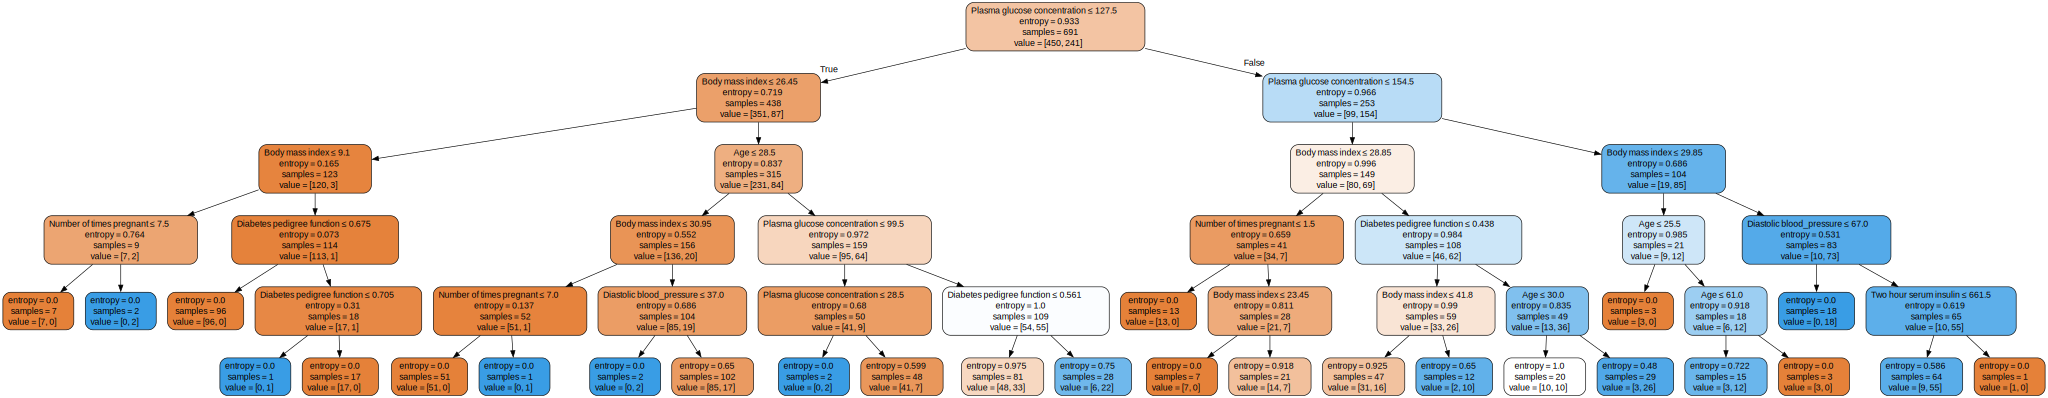

In [25]:
#print(export_text(dtcv1, feature_names=pima_fnames))
dot_datav1 = tree.export_graphviz(dtcv1, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=pima_fnames) 
graphv1 = graphviz.Source(dot_datav1) 
graphv1#.render(format='png') # Big trees are not very easy to examine on the notebook, so you may uncomment the render call to save them to a PNG file so that you can check out the graph elsewhere.

In [26]:
#print(export_text(dtcv2, feature_names=pima_fnames))
dot_datav2 = tree.export_graphviz(dtcv2, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=pima_fnames) 
graphv2 = graphviz.Source(dot_datav2) 
graphv2#.render(format='png') # Big trees are not very easy to examine on the notebook, so you may uncomment the render call to save them to a PNG file so that you can check out the graph elsewhere.

## 3.4. **Using SHAP Values for interpretability**

We can utilize SHAP values to tackle some of the shortcomings mentioned on the previous section:
- SHAP is much more practical when dealing with, for example, a very deep tree with many nested conditions, as it offers a single importance value per feature. In this sense, it summarizes the explanatory information that is spread among the branches of the tree, although SHAP values **do not** necessarily offer the same interpretation you would extract from a tree's branches.
- SHAP, as a post-hoc explainability method, can endow non-interpretable models (such as Random Forests) with interpretability.

SHAP still has a problem with semantic significance (i.e. features having meaning). Because it only gauges the importance of features, we are still fully dependant on those features (and their impact) offering understandable insight on the problem.

We'll see how to generate both **global** and **local** explanations with SHAP:

### **Global explanations**

In [27]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# Building the explainers and computing Shapley values
# Unbound DT
explainerTreeC = shap.TreeExplainer(dtc)
shap_values_DTC = explainerTreeC(x_test)
# Limited-depth DT
explainerTree5C = shap.TreeExplainer(dtc5)
shap_values_DTC5 = explainerTree5C(x_test)
# Random Forest
explainerTreeRFC = shap.TreeExplainer(rfc)
shap_values_RFC = explainerTreeRFC(x_test)

explainers = [explainerTreeC, explainerTree5C, explainerTreeRFC]

In [28]:
# A general commentary on the shap_values_{model} indexing: the SHAP library interprets any classification as multi-class classification (you will see later that indexing is not needed for regressors), which means we need to specify
# the class we're explaining for. Then, [a, b, c] ---> a selects the rows (instances on the dataset), b selects the columns (variables on the dataset), c selects the class (so, 0 for tested_negative, 1 for tested_positive).
# You may alter the plots to work with limited instance ranges, different column sets, or even for the opposite class.

shap.summary_plot(shap_values_DTC[:,:,1])

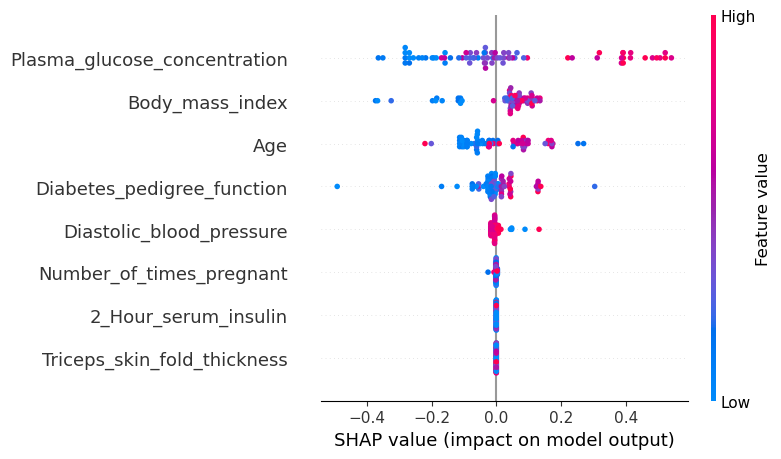

In [29]:
shap.summary_plot(shap_values_DTC5[:,:,1])

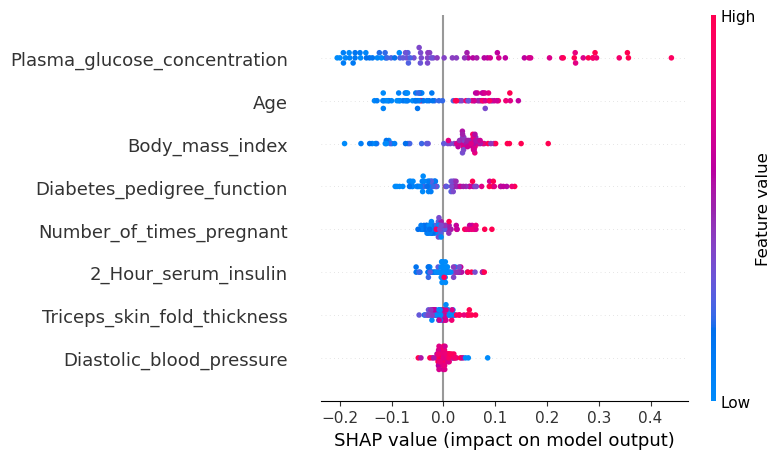

In [30]:
shap.summary_plot(shap_values_RFC[:,:,1])

---

In [16]:
## this code is developed by Pablo Miguel Perez-Ferreiro

# Equivalent for Regressors
# Unbound DT
explainerTreeR = shap.TreeExplainer(dtr)
shap_values_DTR = explainerTreeR(x_test)
# Limited-depth DT
explainerTree5R = shap.TreeExplainer(dtr5)
shap_values_DTR5 = explainerTree5R(x_test)
# Random Forest
explainerTreeRFR = shap.TreeExplainer(rfr)
shap_values_RFR = explainerTreeRFR(x_test)

explainers_r = [explainerTreeR, explainerTree5R, explainerTreeRFR]

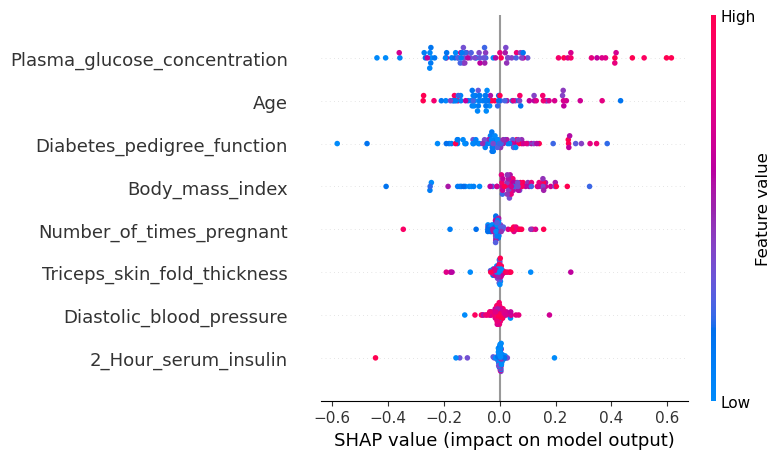

In [17]:
shap.summary_plot(shap_values_DTR)

In [18]:
shap.summary_plot(shap_values_DTR5)

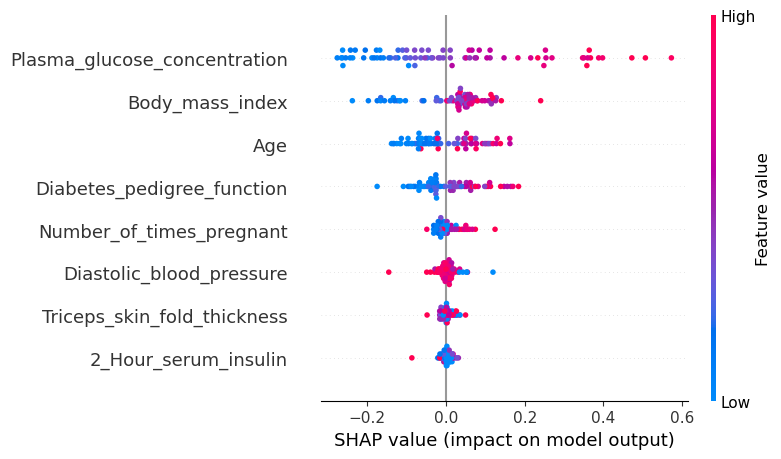

In [19]:
shap.summary_plot(shap_values_RFR)

---
### Exercise I1.2

Now you have an alternative explanation tool against which you can contrast the insight you extracted on **Exercise I1.1**, and some knowledge onto how the Random Forest is predicting. Try to interpret the graphs corresponding to the Classifier alternatives:
- Do the SHAP values for the Decision Trees match your inspection of their graphical representation?
- Do you find significant differences between the Decision Trees and the Random Forest?

It is a good thing if you read [SHAP documentation](https://shap.readthedocs.io/en/latest/) in order to understand better how to interpret the generated plots. Keep in mind that the answer for any of these questions may be negative, but you should still try to theorise as to **why** (justify your responses).

### **Local explanations**

Keep in mind that, for a local explanation, we may justify a **wrong** prediction. This can be misleading, so please pay close attention to it.

----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 0:
The real output class is: False
The predicted output class by model TREE is: True


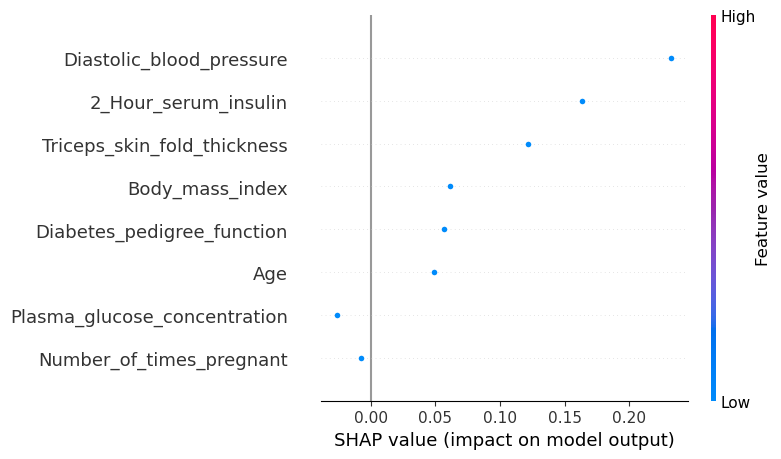

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model TREE5 is: False


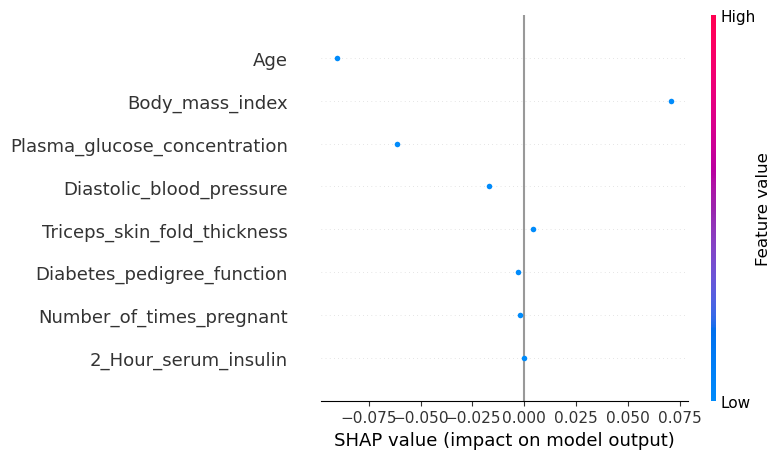

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model RF is: False


----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 24:
The real output class is: False
The predicted output class by model TREE is: False


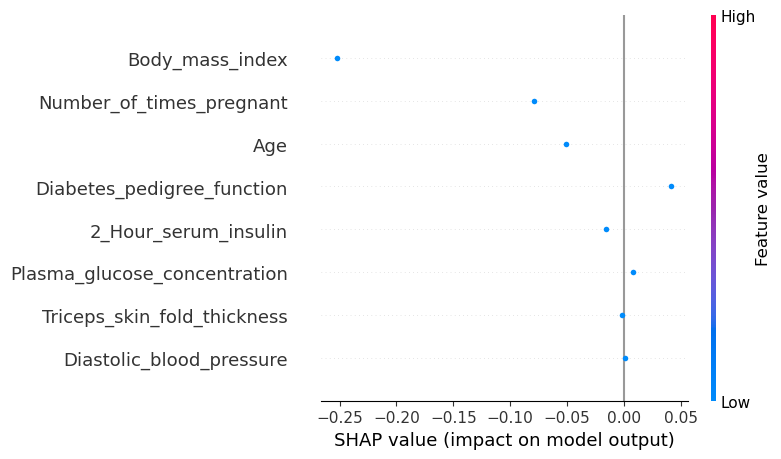

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model TREE5 is: False


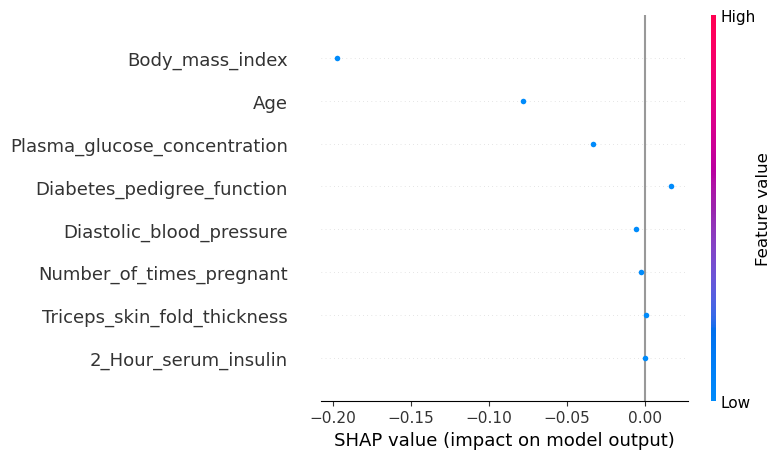

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model RF is: False


----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 59:
The real output class is: True
The predicted output class by model TREE is: False


----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model TREE5 is: False


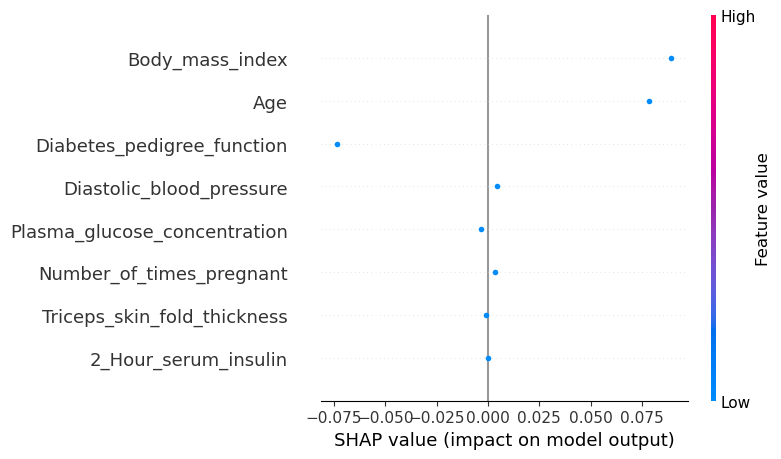

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model RF is: True


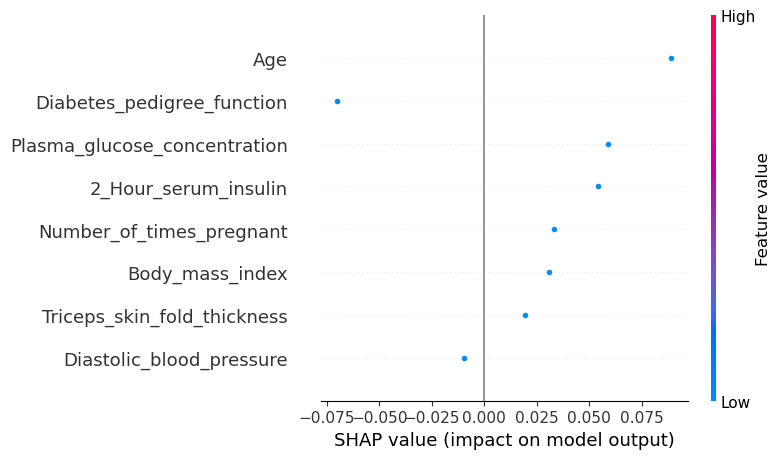

----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 76:
The real output class is: True
The predicted output class by model TREE is: True


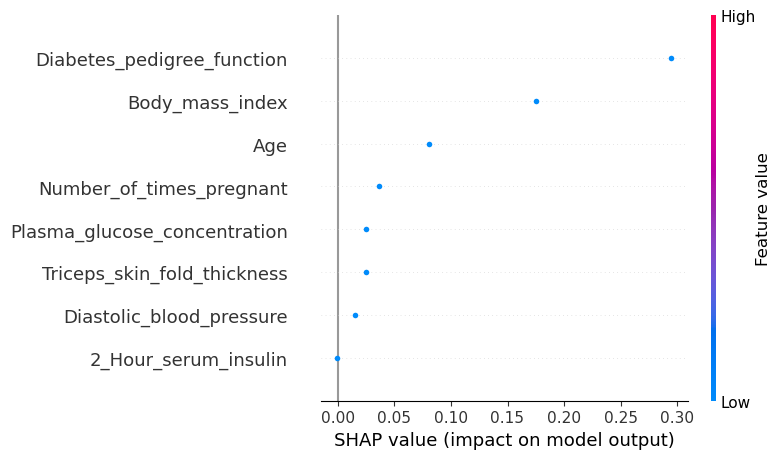

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model TREE5 is: True


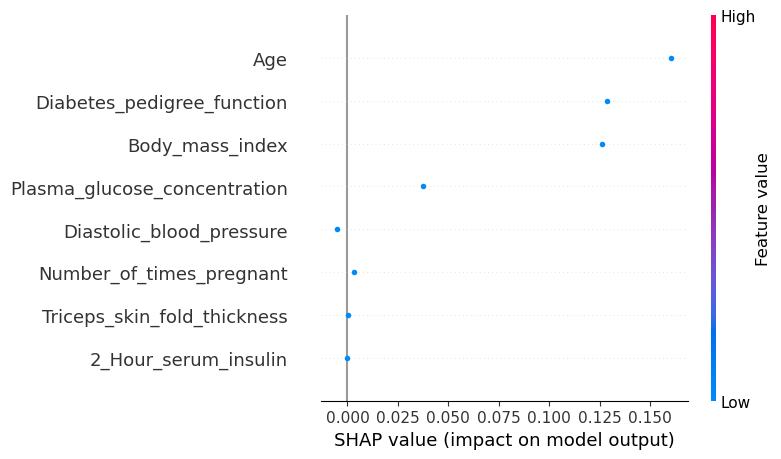

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model RF is: True


----------------------------------------------------------------------------------------------------------------------------


In [20]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

for instance in [0, 24, 59, 76]: # specific cases, feel free to alter them
    print('----------------------------------------------------------------------------------------------------------------------------')
    print(f'\nWORKING WITH INSTANCE {instance}:\nThe real output class is: {y_test.iloc[instance]}')
    for model, model_name, explainer in zip(models, models_names, explainers):
        print(f'The predicted output class by model {model_name} is: {model.predict(x_test.iloc[instance : instance+1])[0]}')
        shap_values = explainer(x_test.iloc[instance : instance+1])
        shap.summary_plot(shap_values[:,:,1])
        print('----------------------------------------------------------------------------------------------------------------------------')

---

----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 0:
The real output class is: 0.0
The predicted output class by model TREE-R is: 0.0


----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model TREE5-R is: 0.25


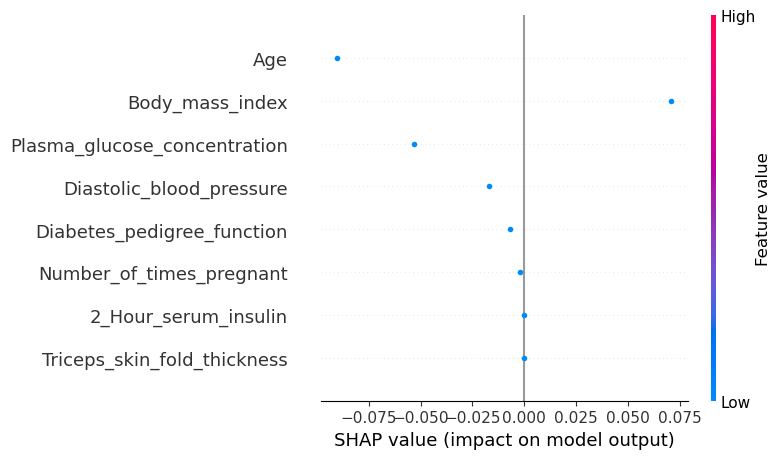

----------------------------------------------------------------------------------------------------------------------------
The predicted output class by model RF-R is: 0.402


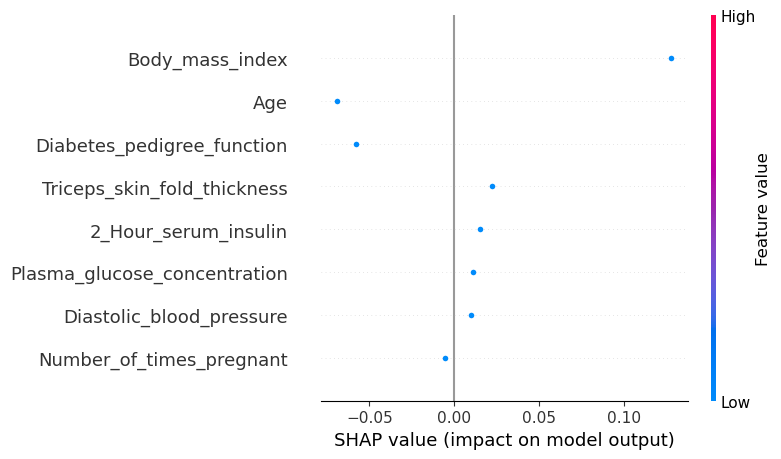

----------------------------------------------------------------------------------------------------------------------------


In [21]:
## this code is developed by Pablo Miguel Perez-Ferreiro

# We will only execute one instance for regression to avoid cluttering the notebook.
for instance in [0]:
    print('----------------------------------------------------------------------------------------------------------------------------')
    print(f'\nWORKING WITH INSTANCE {instance}:\nThe real output class is: {y_test_num[instance]}')
    for model, model_name, explainer in zip(models_r, models_r_names, explainers_r):
        print(f'The predicted output class by model {model_name} is: {model.predict(x_test.iloc[instance : instance+1])[0]}')
        shap_values = explainer(x_test.iloc[instance : instance+1])
        shap.summary_plot(shap_values)
        print('----------------------------------------------------------------------------------------------------------------------------')

---
### Exercise I1.3

Have a look at SHAP's [API reference](https://shap.readthedocs.io/en/latest/api.html#plots). So far, we have only used the basic summary plot, but one of the library's greatest strengths is its rich plotting environment. Try your hand at generating new plots (both global and local) following the code given during the section. Do you think they offer better information than the summaries we were using? Which plotting options do you think would be the best at explaining the problem at hand to a layperson? Would your answer change if the explanations were meant for an expert?

In [22]:
# You may need to execute the following for some of the plots to work
# shap.initjs()

## 3.5. **Trade-offs**

We have now studied two ways of sheding light on how to make ML models more interpretable: either through direct inspection when the model allows it (because it is interpretable-by-design), or applying SHAP as a post-hoc method. It is important, however, to note that interpretability, while very important, is not to be gauged in a vacuum. A very interpretable model that performs poorly is useless: it may explain its reasoning, but the reasoning is flawed in itself and there is no point in understanding it.

In a less extreme situation, we may find ourselves faced with a decision between a highly interpretable model that performs reasonably well, and a less interpretable model that performs even better. Whatever we choose, we have a trade-off, and a good way to decide is through the construction of a Pareto front that allows us to objectively compare the relative virtues of all options, presenting a performance metric against an interpretability metric:

The data for the Pareto front is as follows:
	-For model TREE, accuracy is 0.675 with a total of 133 leaf nodes.
	-For model TREE5, accuracy is 0.727 with a total of 27 leaf nodes.
	-For model RF, accuracy is 0.818 with a total of 199.5 leaf nodes.


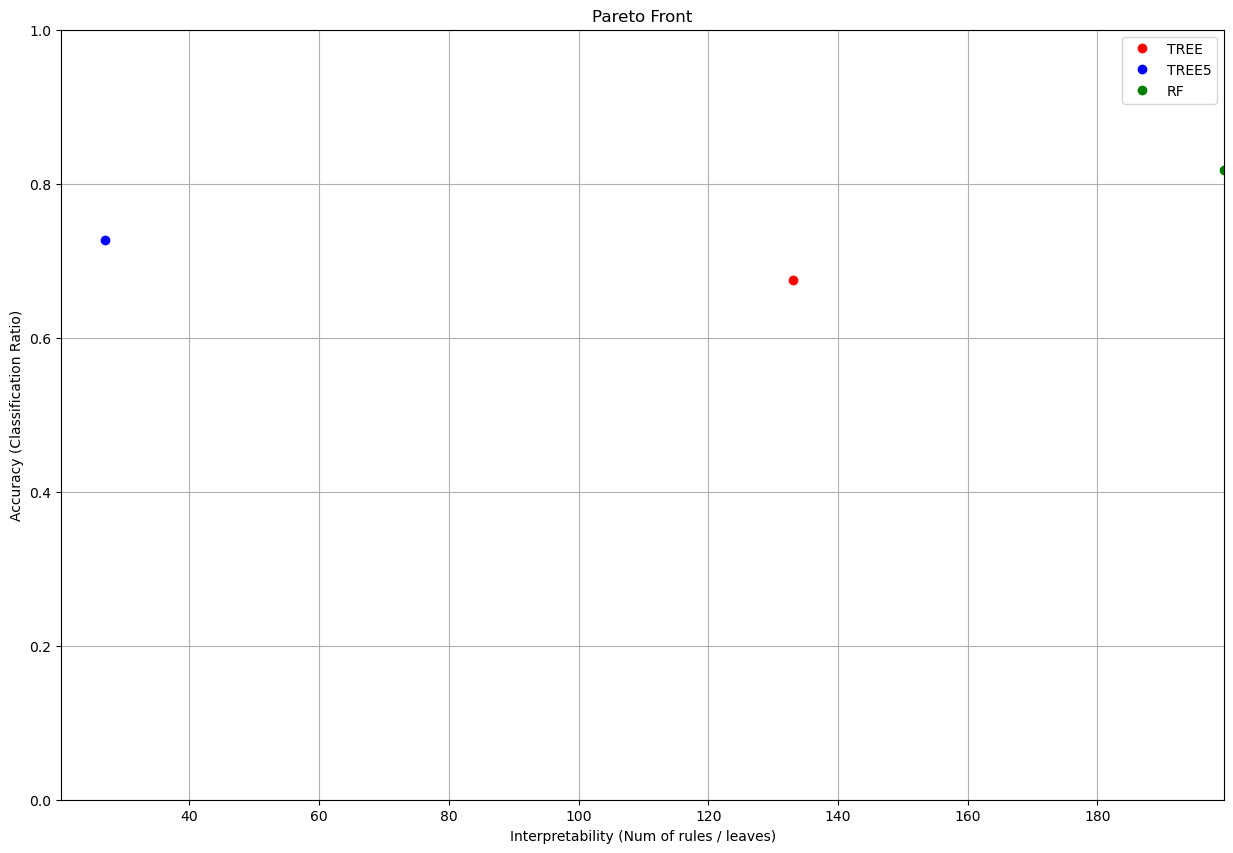

In [23]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# Building and visualizing the Pareto front with predictive accuracy versus number of leaf nodes, which can be understood as a surrogate for interpretability (remember
# how the largest tree was much harder to visually inspect)

limits = [min([dtc.get_n_leaves(), dtc5.get_n_leaves()])*0.75, max([dtc.get_n_leaves(), dtc5.get_n_leaves()])*1.5]
# Random Forest is a black box model and there is no easy, fair way to give it a nominal leaf node amount. We settle here for multiplying the largest tree x1.5 (penalty for opaqueness).
x_axis = [dtc.get_n_leaves(), dtc5.get_n_leaves(), limits[1]]

print("The data for the Pareto front is as follows:")
for name, accuracy, leaves in zip(models_names, models_acc, x_axis):
    print(f'\t-For model {name}, accuracy is {accuracy} with a total of {leaves} leaf nodes.')
    
plt.figure(figsize=[15,10])
plot_pareto_front(x_axis, models_acc, models_names, 'Accuracy (Classification Ratio)','Interpretability (Num of rules / leaves)', limits[0], limits[1])

The data for the Pareto front is as follows:
	-For model TREE, accuracy is 0.675 with a SHAP length of 553.
	-For model TREE5, accuracy is 0.727 with a SHAP length of 561.
	-For model RF, accuracy is 0.818 with a SHAP length of 557.


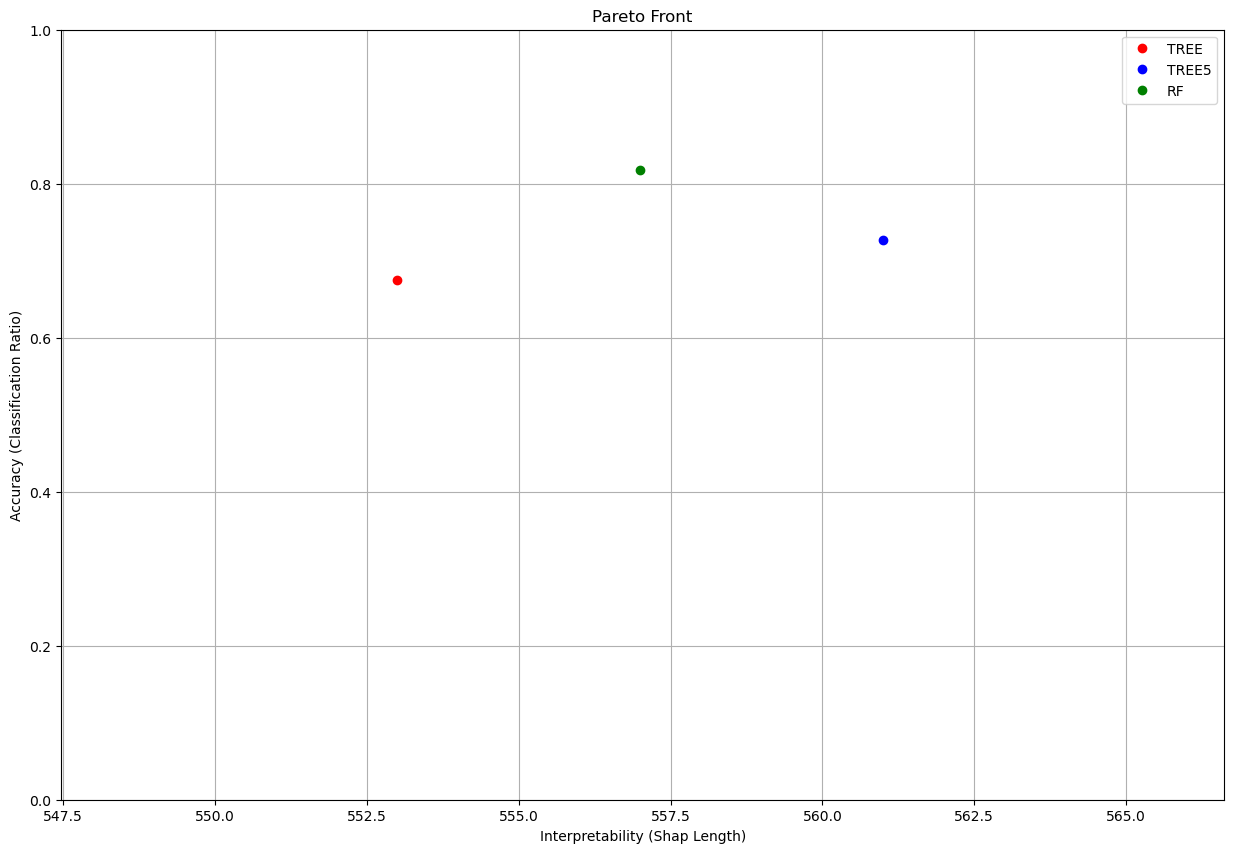

In [24]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# Building and visualizing the Pareto front with Accuracy versus Shap Length

x_axis = [get_shap_explanation_length(explainer.shap_values(x_test)[:,:,1]) for explainer in explainers]
limits = [min(x_axis)*0.99, max(x_axis)*1.01]

print("The data for the Pareto front is as follows:")
for name, accuracy, shap_l in zip(models_names, models_acc, x_axis):
    print(f'\t-For model {name}, accuracy is {accuracy} with a SHAP length of {shap_l}.')

plt.figure(figsize=[15,10])
plot_pareto_front(x_axis,models_acc,models_names,'Accuracy (Classification Ratio)','Interpretability (Shap Length)',limits[0],limits[1])

# 4. **A more integral approach: InterpretML**

In the previous section, we followed the full process of building an intelligent system and trying to understand how it works. However, thanks to the growing interest in AI trustworthiness and explainability (which motivates this subject!), we now have many tools at our disposal that make the life of a trustworthy AI engineer much easier. The [InterpretML](https://interpret.ml/) Python library is intended to do just that; play around with it to round up this first practical session.

In [25]:
## this code is developed by Jose Maria Alonso-Moral

# This is InterpretML's own approach: a 'glass-box' model that aims to provide opaque-model performance with full explainability.
# As such, it is already designed with explanations in mind, and supports them natively.
ebm = ExplainableBoostingClassifier()
ebm.fit(x_tr, y_tr)

# This will provide global insight on the model. You can change tabs to study the effect of individual variables, and also of interactions between pairs of them.
ebm_global = ebm.explain_global()
show(ebm_global)

In [26]:
## this code is developed by Jose Maria Alonso-Moral

# This code explains local instances
instance = 0
ebm_local = ebm.explain_local(x_test.iloc[instance : instance+1], y_test.iloc[instance : instance+1])
show(ebm_local)

## Exercise I1.4

Now that you've reached the end of this first practical session, you have all the tools needed to autonomously perform the following task. Use the code below to import the SONGS dataset, present on your workspace, which contains 2017 data instances representing songs from a [Kaggle competition](https://www.kaggle.com/geomack/spotifyclassification). The dataset is intended to serve for the classification problem of predicting if the song will be 'Like' or 'Dislike'.

With the dataset imported, follow the process laid out through this notebook to explain the **global** behaviour of the model. Then, find a song you like (and another song that you don't like) on the dataset (using the code provided), and **locally explain** the predictions made by a decision tree with a good interpretability-accuracy trade-off and Random Forest. Discuss all your findings.

In [27]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# importing the dataset
file_songs = 'testlib/SONGS/SONGS.arff'
file_songs_data = 'testlib/SONGS/spotifyData.csv'
with open(file_songs) as f:
    songs_data_value, songs_attributes = loadarff(f)
    f.close()
with open(file_songs_data) as f:
    song_names = pd.read_csv(file_songs_data).loc[:, ['artist', 'song_title', 'id']]
    f.close()
songs_fnames=["acoustics","danceability","duration","energy","instrumentalness","key","liveness","loudness","mode","speechiness","tempo","timeSignature","valence"]
songs_class_names = ['Dislike','Like']

# You don't need to perform a train/test split or validation of the models later. 
songs_class_names = np.array(songs_class_names)
songs_feature_names = np.array(songs_attributes.names())
df_songs=pd.DataFrame(songs_data_value)
df_songs.columns = songs_feature_names
songs_target = df_songs.pop('class')
songs_target_onehot = pd.get_dummies(songs_target)[b'2'] 
X_songs = df_songs
y_songs = songs_target_onehot
# You don't need the numerical variant, as you don't need to do the Regression equivalents.

print(f'Class names for the PIMA Dataset:\n\t{", ".join(list(songs_class_names))}\nFeature names for the PIMA Dataset:\n\t{", ".join(list(songs_feature_names))}')

Class names for the PIMA Dataset:
	Dislike, Like
Feature names for the PIMA Dataset:
	acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence, class


In [28]:
# You can use this code to search for text on either the artist or the title of the song and record its ID, to search for it on the actual prediction dataset later.
# If you can't seem to find an artist or song, it may not be on the dataset (which is not that exhaustive) or you may be writing it differently to the dataset's record
# in which case you can try to spell it differently (such as 'michael' instead of 'Michael'). A trick you can use, because str.contains() treats its input like a regular
# expression, is to write just the middle part: instead of 'Billie', just write 'illie' to avoid upper/lowercase conflicts.

artist_songs = song_names[song_names['artist'].str.contains("Michael Jackson")]
named_songs = song_names[song_names['song_title'].str.contains("Billie Jean")]